# Parity Classification Using VQC

## Import All Package

In [1]:
import pickle
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_ibm_provider import IBMProvider
from qiskit import Aer
from numpy import pi
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.compiler import transpile, assemble
import matplotlib.pyplot as plt
from qiskit import execute

## Load IBMQ Provider

In [29]:
provider = IBMProvider()
print(provider.backends())

[<IBMBackend('ibmq_qasm_simulator')>, <IBMBackend('ibmq_quito')>, <IBMBackend('simulator_mps')>, <IBMBackend('simulator_stabilizer')>, <IBMBackend('ibm_nairobi')>, <IBMBackend('ibmq_jakarta')>, <IBMBackend('ibm_perth')>, <IBMBackend('ibmq_lima')>, <IBMBackend('ibmq_belem')>, <IBMBackend('simulator_extended_stabilizer')>, <IBMBackend('simulator_statevector')>, <IBMBackend('ibmq_manila')>, <IBMBackend('ibm_lagos')>]


## Load Model Data and Parameters

In [3]:
num_qubits = 5
num_layers = 2
with open(f'data_{num_qubits}_{num_layers}.pkl', 'rb') as f:
    data = pickle.load(f)
data

{'X_train': array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 1., 1., 1.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1.],
        [0., 1., 0., 1., 0.],
        [0., 1., 0., 1., 1.],
        [0., 1., 1., 0., 1.],
        [0., 1., 1., 1., 0.],
        [0., 1., 1., 1., 1.],
        [1., 0., 0., 1., 0.],
        [1., 0., 1., 0., 1.],
        [1., 0., 1., 1., 0.],
        [1., 0., 1., 1., 1.],
        [1., 1., 0., 0., 0.],
        [1., 1., 0., 1., 0.],
        [1., 1., 0., 1., 1.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]]),
 'X_test': array([[0., 1., 1., 0., 0.],
        [1., 0., 1., 0., 0.],
        [1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 1.],
        [0., 0., 0., 1., 0.],
        [1., 1., 0., 0., 1.],
        [1., 0., 0., 1., 1.],
        [1., 0., 0., 0., 0.]]),
 'y_train': arr

In [4]:
parameters = data['parameters']
X_train = data['X_train']
X_test = data['X_test']
parameters

array([[[ 0.30970308,  2.8957012 ,  0.07725242],
        [ 0.37450665,  1.6375909 ,  1.841041  ],
        [ 2.5097609 ,  2.9995108 ,  2.0818458 ],
        [ 4.066137  ,  0.11089341,  2.537333  ],
        [ 1.6271863 ,  4.7513943 ,  1.5775045 ]],

       [[ 5.1900697 ,  0.32366133,  0.2733658 ],
        [ 0.17422806,  1.7273018 ,  0.17497867],
        [ 6.0893097 ,  1.3337643 ,  1.94051   ],
        [-0.0607143 ,  1.3080354 ,  1.5810583 ],
        [ 0.60667646,  0.20470195,  4.124477  ]]], dtype=float32)

## Build Quantum Circuit

In [5]:
def INPUT(circuit, num_qubits, inputs, num_layers):
    for i in range(num_qubits):
        if inputs[i] == 1:
            circuit.x(i)
def build_circuit(inputs):
    circuit = QuantumCircuit(num_qubits, 1)
    INPUT(circuit, num_qubits, inputs, num_layers)
    circuit.barrier()
    for a in range(num_layers):
        for k in range(num_qubits):
            circuit.rz(parameters[a,k,0],k)
            circuit.ry(parameters[a,k,1],k)
            circuit.rz(parameters[a,k,2],k)
        for j in range(num_qubits):
            circuit.cx(j, (j+1) % num_qubits)    
    circuit.barrier()
    circuit.measure(0, 0)
    return circuit

In [6]:
circuits = []
for data in X_train:
    circuits.append(build_circuit(data))
for data in X_test:
    circuits.append(build_circuit(data))

## Use Simulator

In [8]:
simulator = Aer.get_backend('aer_simulator')
job_sim = simulator.run(circuits, shots=2000000)
counts_sim = job_sim.result().get_counts()
expZ_sim = []
for count in counts_sim:
    expZ_sim.append((count['0'] - count['1']) / (count['0'] + count['1']))
expZ_sim = np.array(expZ_sim)
expZ_sim

array([-0.837723,  0.906412, -0.846013,  0.866427, -0.822867,  0.897926,
        0.874057, -0.806068, -0.812718,  0.883394,  0.831059,  0.859702,
       -0.785105, -0.738275,  0.797758,  0.767805, -0.842221, -0.709923,
        0.705408, -0.776509,  0.829033, -0.904311, -0.877585,  0.802433,
       -0.756858, -0.872252, -0.675114, -0.791212,  0.917955,  0.641718,
        0.666584,  0.605621])

## Use Real Quantum Computer

In [ ]:
mapped_circuit = transpile(circuits, backend=backend)
job = backend.run(mapped_circuit, shots=20000)
job.job_id()

In [30]:
job = provider.retrieve_job('chqv0rinajhpa663mqag')
job.job_id(), job.backend()

('chqv0rinajhpa663mqag', <IBMBackend('ibmq_quito')>)

In [31]:
counts = job.result().get_counts()
expZ = []
for count in counts:
    expZ.append((count['0'] - count['1']) / (count['0'] + count['1']))
expZ = np.array(expZ)
expZ

array([-0.2718,  0.2922, -0.2761,  0.3326, -0.252 ,  0.3251,  0.3621,
       -0.2384, -0.231 ,  0.2983,  0.2688,  0.3335, -0.2793, -0.2253,
        0.2976,  0.4286, -0.3108, -0.2171,  0.3032, -0.2523,  0.3401,
       -0.2838, -0.295 ,  0.3298, -0.3018, -0.239 , -0.2228, -0.2187,
        0.3875,  0.2619,  0.3176,  0.3605])

## Save Exceted Value

In [32]:
with open(f'ParityData.pkl', 'wb') as f:
    pickle.dump({'counts': counts, 
                 'expZ': expZ, 
                 'counts_sim': counts_sim, 
                 'expZ_sim': expZ_sim}, f)

In [33]:
with open(f'ParityData.pkl', 'rb') as f:
    rawdata = pickle.load(f)
expZ = rawdata['expZ']
expZ_sim = rawdata['expZ_sim']

## Plot Exceted Value

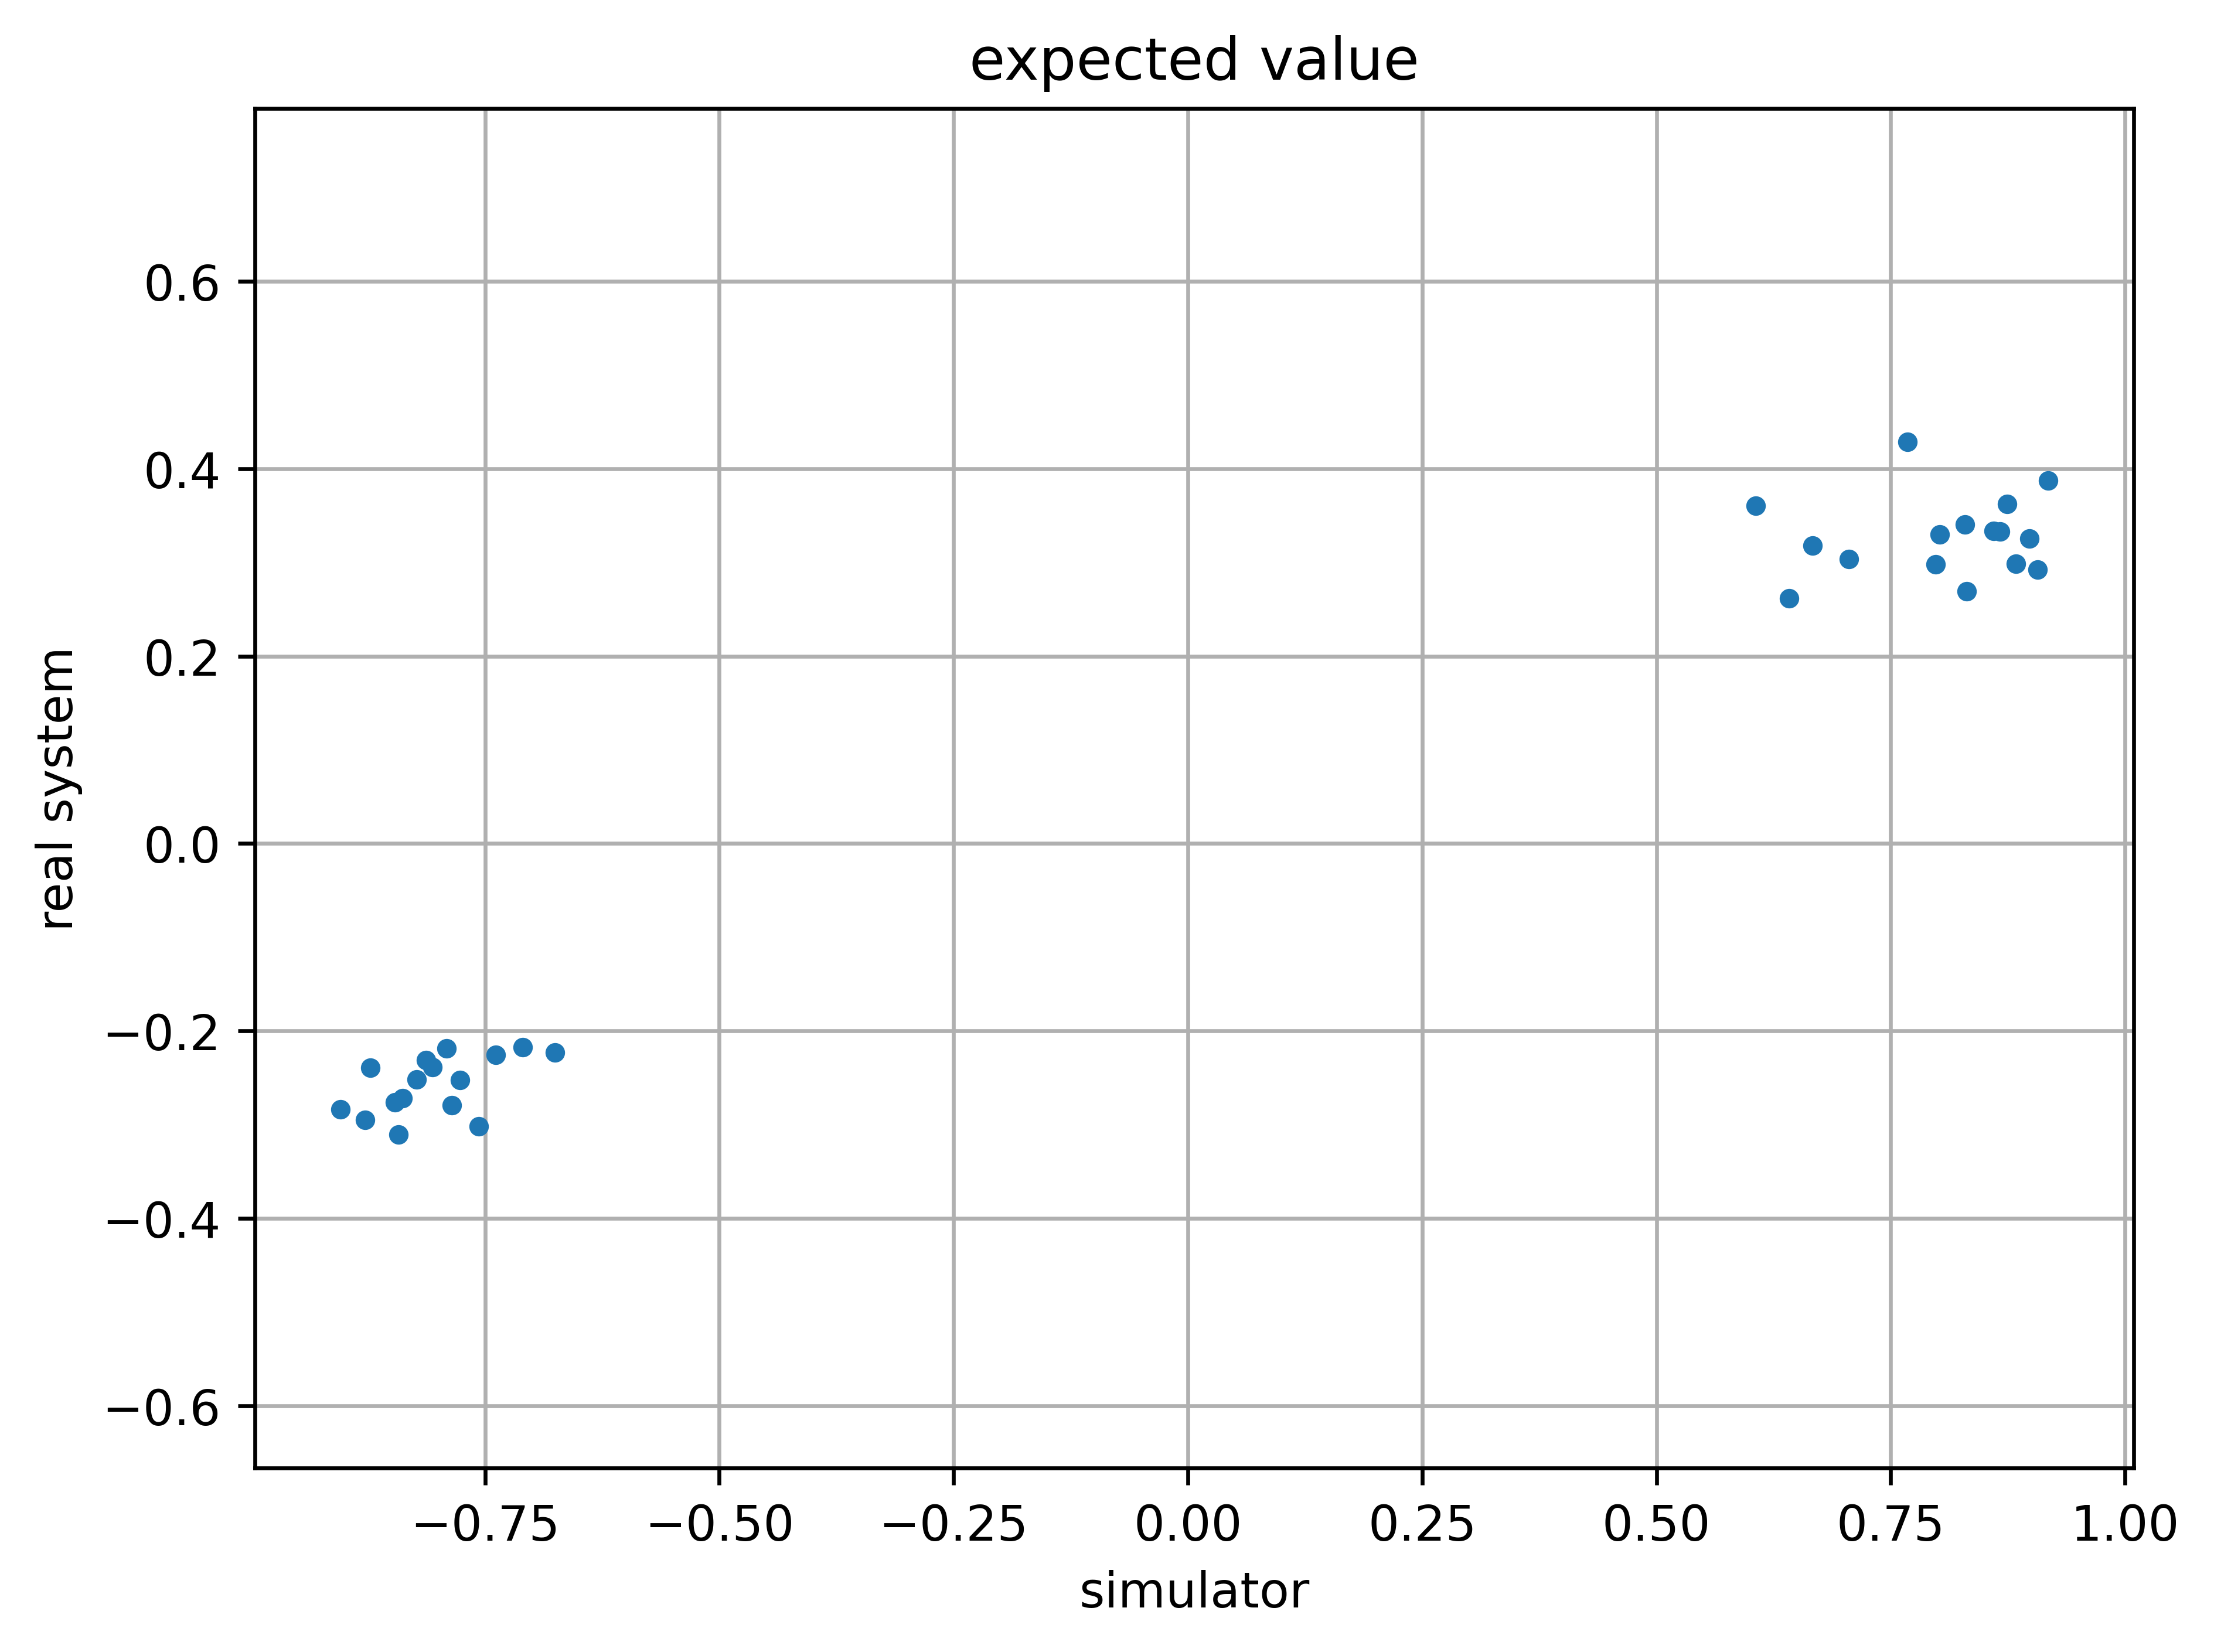

In [34]:
plt.figure(dpi=600)
plt.plot(expZ_sim, expZ, '.')
plt.ylabel('real system')
plt.xlabel('simulator')
plt.title('expected value')
plt.axis('equal')
plt.tight_layout()
plt.grid()
plt.show()